In [1]:
from alphavantage import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

sns.set_style("darkgrid")

In [2]:
data = get_pandas_data(get_daily('MSFT'))

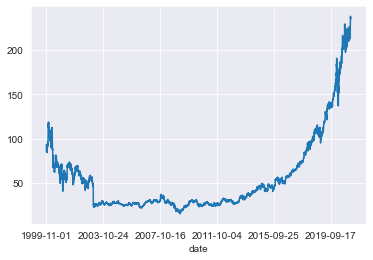

In [3]:
data['open'].plot()

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
data.head()

,open,high,low,close,volume
date,,,,,
1999-11-01,93.25,94.19,92.12,92.37,26630600
1999-11-02,92.75,94.50,91.94,92.56,23174500
1999-11-03,92.94,93.50,91.50,92.00,22258500
1999-11-04,92.31,92.75,90.31,91.75,27119700
1999-11-05,91.81,92.87,90.50,91.56,35083700


In [42]:
def plot_moving_average(series, nn=[90], upper_lower_bond=True):

    """
    series - dataframe with timeseries or any iterable
    nn - rolling window size. int or list(show len(nn) plots 
    with different rolling windows)
    """
    if type(series) != pd.Series:
        series = pd.Series(series)
    
    if type(nn) == int:
        nn = [nn]
        
    for n in nn: 
        rolling_mean = series.rolling(window=n).mean().values

        rolling_std =  series.rolling(window=n).std().values
        if upper_lower_bond:
            upper_bond = rolling_mean+1.96*rolling_std
            lower_bond = rolling_mean-1.96*rolling_std

        plt.figure(figsize=(20,8))
        plt.title("Moving average\n window size = {}".format(n))
        plt.plot(rolling_mean, "g", label="Rolling mean trend")
        
        
        if upper_lower_bond:
            upper_bond = rolling_mean+1.96*rolling_std
            lower_bond = rolling_mean-1.96*rolling_std
            plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
            plt.plot(lower_bond, "r--")
            
        plt.plot(series.values[n:], label="Actual values")
        plt.legend(loc="upper left")
        plt.grid(True)

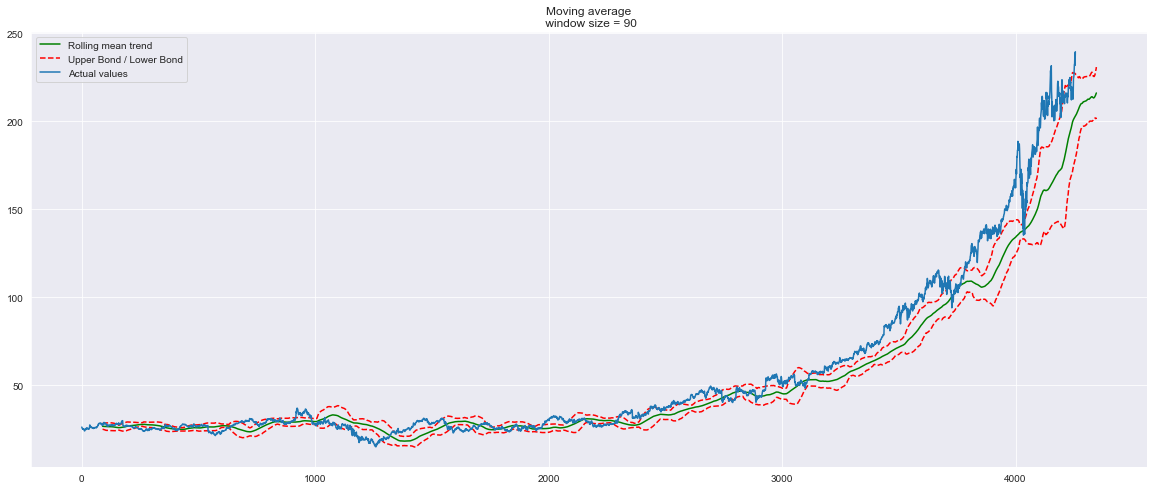

In [45]:
plot_moving_average(data['close'][1000:], 90)

In [15]:
close = data.close

In [16]:
split_size = int(len(data) * 0.8)
train = close[:split_size].values
test = close[split_size:].values

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()

In [18]:
train = train.reshape(-1,1)
test = test.reshape(-1,1)

In [19]:
train = scaler_train.fit_transform(train).reshape(-1)
test = scaler_test.fit_transform(test).reshape(-1)

In [20]:
ema = 0.0
gamma = 0.1
for ti in range(len(train)):
    ema = gamma*train[ti] + (1-gamma)*ema
    train[ti] = ema

# Used for visualization and test purposes
all_data = np.concatenate([train, test],axis=0)

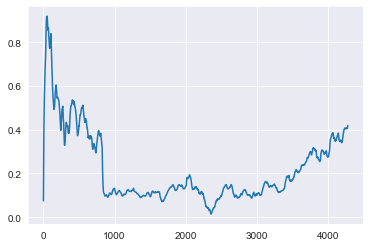

In [21]:
plt.plot(train)

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import gradient_boosting
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [23]:
def make_window_data(data, window):
    X = np.zeros([len(data) - window, window])

    for i in range(len(X)):
        X[i,:] = data[i:i+window]

    Y = data[window:].reshape(-1,1)
    
    return X, Y

In [24]:
predict_window = 100
X_train, Y_train = make_window_data(train, predict_window)

In [25]:
X_test, Y_test = make_window_data(test, predict_window)

In [26]:
model = KNeighborsRegressor(n_neighbors=35)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)

Text(0.5, 1.0, 'KNN')

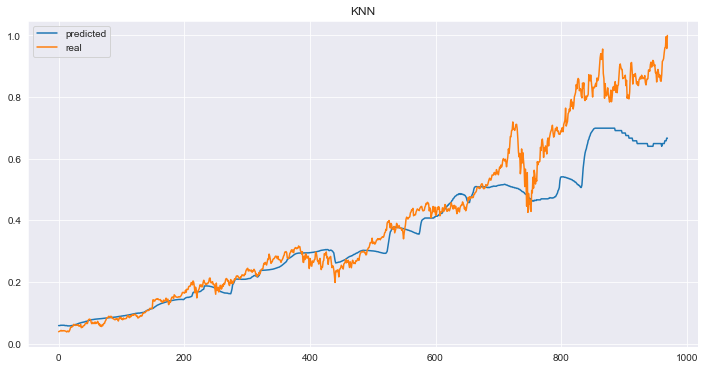

In [27]:
plt.figure(figsize=(12,6))
plt.plot(predicted)
plt.plot(Y_test)
plt.legend(["predicted", "real"])
plt.title("KNN")

In [28]:
def long_term_prediction(model, test, predict_window):
    ltp = np.zeros(len(test))
    ltp[:predict_window] = test[:predict_window]
    for i in range(predict_window, len(test)):
        ltp[i] = model.predict(ltp[i - predict_window:i].reshape(1,-1))

    return ltp

In [39]:
ltp = long_term_prediction(model, test, predict_window)

Text(0.5, 1.0, 'KNN')

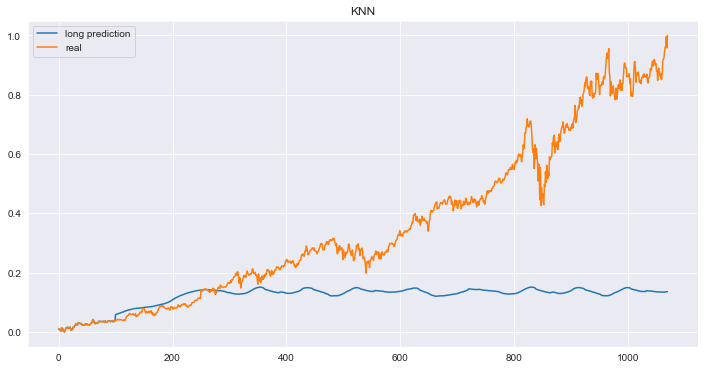

In [40]:
plt.figure(figsize=(12,6))
plt.plot(ltp)
plt.plot(test)
plt.legend(["long prediction", "real"])
plt.title("KNN")

In [30]:
def model_pipeline(model, train, test, predict_window):
    X_train, Y_train = make_window_data(train, predict_window)
    X_test, Y_test = make_window_data(test, predict_window)
    
    model = model
    model.fit(X=X_train, y=Y_train)
    predicted = model.predict(X_test)
    
    ltp = long_term_prediction(model, test, predict_window)
    
    plt.figure(figsize=(12,6))
    plt.plot(predicted)
    plt.plot(Y_test)
    plt.legend(["predicted", "real"])
    plt.title(str(model)[:-2])
    plt.show()
    
    plt.figure(figsize=(12,6))
    plt.plot(ltp)
    plt.plot(test)
    plt.legend(["long term prediction", "real"])
    plt.title(str(model)[:-2])
    
    return model

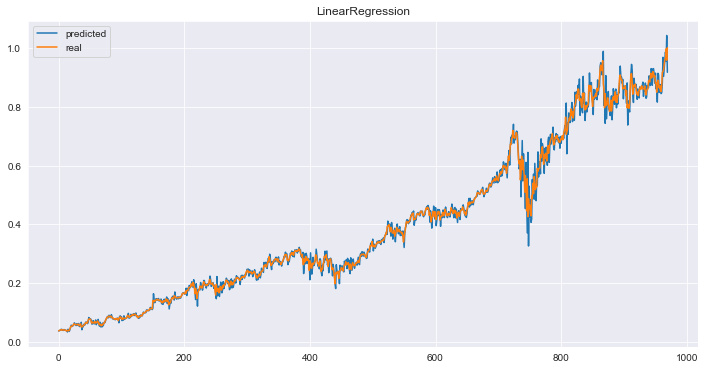

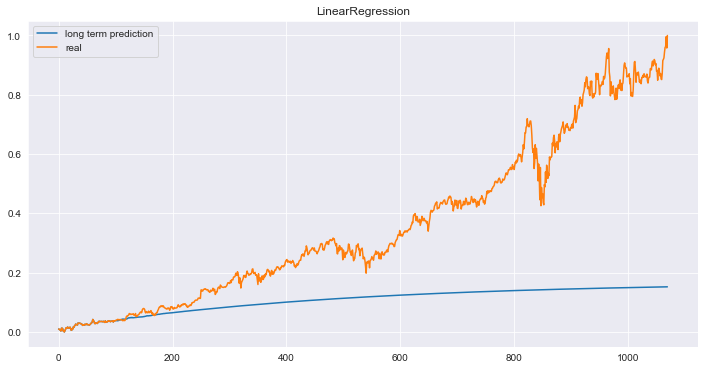

In [31]:
_ = model_pipeline(LinearRegression(), train, test, 100)

<ipython-input-30-a2628027cedd>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X=X_train, y=Y_train)


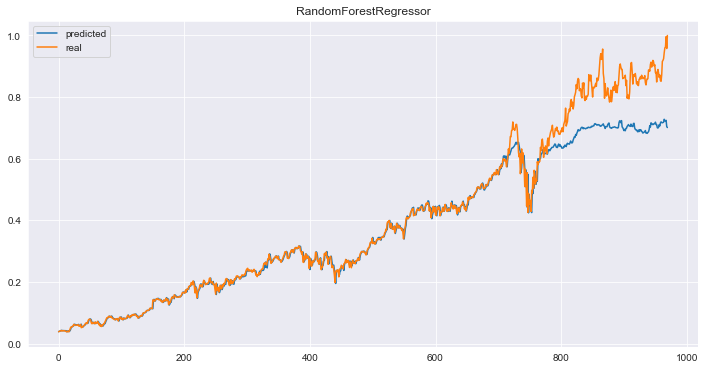

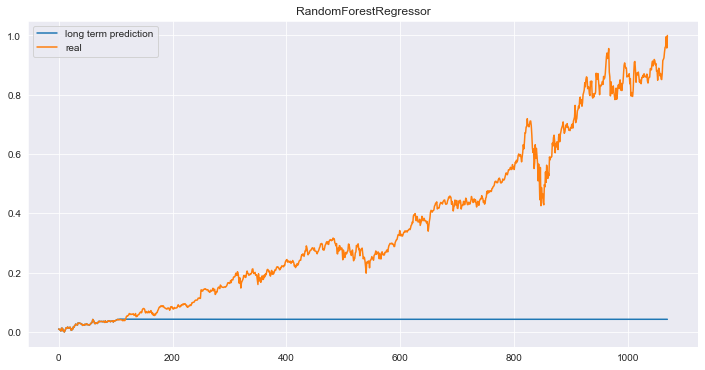

In [32]:
_ = model_pipeline(RandomForestRegressor(), train, test, 100)

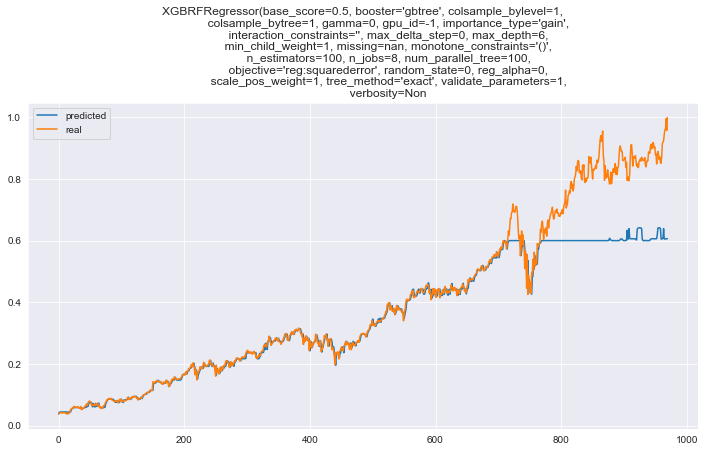

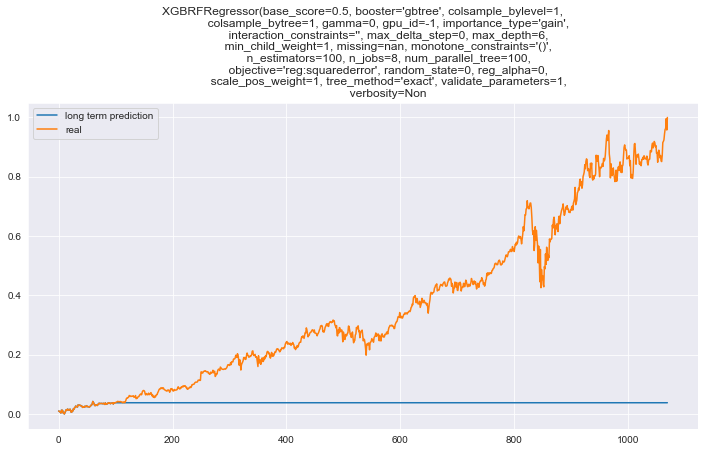

In [41]:
import xgboost
_ = model_pipeline(xgboost.XGBRFRegressor(), train, test, 100)